In [425]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [427]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

### Data preparation and model configuration

In [455]:
# ============= Import required packaages ==============
import re, time, os
import pickle

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
# from custom_classes_defs.fnet import *
# from custom_classes_defs.hed import *

import keras
import numpy as np
import keras.backend as KB

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 32
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt
# -------------------------------------------------------

In [429]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


In [430]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(seed=RND_STATE)

#for input_path, target_path in zip(pets.input_img_paths[:10], pets.target_img_paths[:10]):
#    print(input_path, "|", target_path)
print(f"training data (size = {len(train_dataset)*BATCH_SIZE})")
print(f"validation data (size = {len(valid_dataset)*BATCH_SIZE})")
print(f"test data (size = {len(test_dataset)*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])


Number of samples: 7390
training data (size = 768)
validation data (size = 768)
test data (size = 5920)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)


In [431]:
# # Display input image #idx
# idx = 19
# display(Image(filename=pets.input_img_paths[idx]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(load_img(pets.target_img_paths[idx]))
# display(img)

In [432]:

# Model configurations
conf = model_config(
    epochs=20,
    batch_size=BATCH_SIZE,
    shuffle=False,
    scaling=1,
    verbose=1,
    save_path='./data',
    augmentation=False,
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    new_training_session=True
)

## ====== Define callbacks ====
earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(conf.save_path, "unet_pets.keras"), 
    save_best_only=True
)

schedule_lr = keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: lr * KB.exp(-0.1) if (epoch > 10) else lr,
    verbose=1
)

callbacks = [
    reduce_lr_on_plateau,
    checkpoint,
    # schedule_lr,
    earlystopping
]

conf.set( validation_data=valid_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    loss="sparse_categorical_crossentropy",
    metrics= ['accuracy']
)

conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 20
                    batch_size: 32
                       shuffle: False
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <keras.src.callbacks.ReduceLROnPlateau object at 0x31d657220>
                              : <keras.src.callbacks.ModelCheckpoint object at 0x31d6569e0>
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 1
                  augmentation: False
new_training_session: True
           save_path: ./data
           threshold: 0.5
           pos_label: 1


### Build model

In [434]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
# m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
model = m_obj.build_model()
# model.summary()
plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------
Total number of parameters: 2,058,979
Total trainable wieghts: 2,055,203
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 2.1059 - accuracy: 0.5957

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 125s 5s/step - loss: 2.1059 - accuracy: 0.5957 - val_loss: 1.7496 - val_accuracy: 0.5020 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.6678

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 95s 4s/step - loss: 1.0238 - accuracy: 0.6678 - val_loss: 1.2593 - val_accuracy: 0.5662 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.7032

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 93s 4s/step - loss: 0.8355 - accuracy: 0.7032 - val_loss: 1.3431 - val_accuracy: 0.5735 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.7222

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 72s 3s/step - loss: 0.7516 - accuracy: 0.7222 - val_loss: 1.5385 - val_accuracy: 0.5753 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.7374

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 85s 4s/step - loss: 0.6969 - accuracy: 0.7374 - val_loss: 1.8416 - val_accuracy: 0.5762 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7500

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 90s 4s/step - loss: 0.6551 - accuracy: 0.7500 - val_loss: 2.2088 - val_accuracy: 0.5768 - lr: 1.0000e-04
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.7615

Corrupt JPEG data: premature end of data segment



Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
24/24 [==============================] - 105s 4s/step - loss: 0.6195 - accuracy: 0.7615 - val_loss: 2.5916 - val_accuracy: 0.5770 - lr: 1.0000e-04
Epoch 8/20
24/24 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.7722

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 105s 4s/step - loss: 0.5887 - accuracy: 0.7722 - val_loss: 2.7005 - val_accuracy: 0.5771 - lr: 5.0000e-05
Epoch 9/20
24/24 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7768

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 106s 4s/step - loss: 0.5764 - accuracy: 0.7768 - val_loss: 2.8900 - val_accuracy: 0.5771 - lr: 5.0000e-05
Epoch 10/20
24/24 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.7825

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 99s 4s/step - loss: 0.5609 - accuracy: 0.7825 - val_loss: 3.0892 - val_accuracy: 0.5771 - lr: 5.0000e-05
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7884

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 124s 5s/step - loss: 0.5451 - accuracy: 0.7884 - val_loss: 3.2424 - val_accuracy: 0.5771 - lr: 5.0000e-05
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7943

Corrupt JPEG data: premature end of data segment



Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
24/24 [==============================] - 107s 4s/step - loss: 0.5294 - accuracy: 0.7943 - val_loss: 3.3600 - val_accuracy: 0.5771 - lr: 5.0000e-05
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.7980

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 100s 4s/step - loss: 0.5200 - accuracy: 0.7980 - val_loss: 3.3153 - val_accuracy: 0.5771 - lr: 2.5000e-05
Epoch 14/20
24/24 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.8004

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 117s 5s/step - loss: 0.5126 - accuracy: 0.8004 - val_loss: 3.3009 - val_accuracy: 0.5771 - lr: 2.5000e-05
Epoch 15/20
24/24 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8042

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 202s 9s/step - loss: 0.5025 - accuracy: 0.8042 - val_loss: 3.2039 - val_accuracy: 0.5771 - lr: 2.5000e-05
Epoch 16/20
24/24 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.8077

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 178s 8s/step - loss: 0.4934 - accuracy: 0.8077 - val_loss: 3.0619 - val_accuracy: 0.5771 - lr: 2.5000e-05
Epoch 17/20
24/24 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.8113

Corrupt JPEG data: premature end of data segment



Epoch 17: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
24/24 [==============================] - 147s 6s/step - loss: 0.4842 - accuracy: 0.8113 - val_loss: 2.8709 - val_accuracy: 0.5771 - lr: 2.5000e-05
Epoch 18/20
24/24 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8148

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 114s 5s/step - loss: 0.4748 - accuracy: 0.8148 - val_loss: 2.6812 - val_accuracy: 0.5771 - lr: 1.2500e-05
Epoch 19/20
24/24 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8149

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 170s 7s/step - loss: 0.4735 - accuracy: 0.8149 - val_loss: 2.3496 - val_accuracy: 0.5774 - lr: 1.2500e-05
Epoch 20/20
24/24 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.8162

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 179s 8s/step - loss: 0.4701 - accuracy: 0.8162 - val_loss: 2.0233 - val_accuracy: 0.5794 - lr: 1.2500e-05
training elapsed time: ___40.22 minutes___
...training completed!


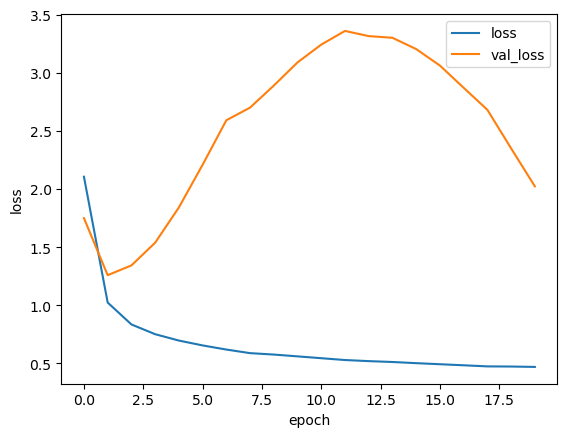

Unable to create unet_pets_callbacks_history.json


In [435]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

train_history = conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name+'_pets_callbacks', 
    plot_history=INTERACTIVE_SESSION
)



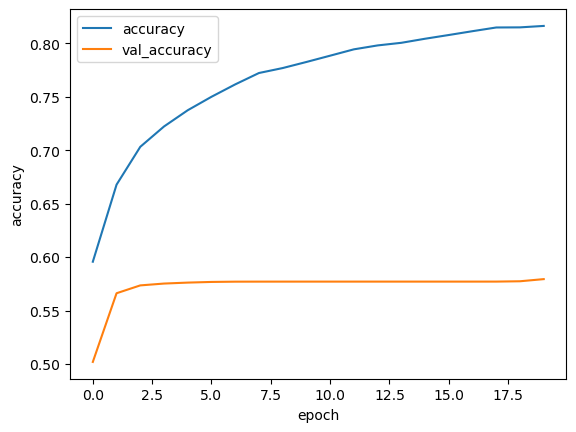

In [472]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

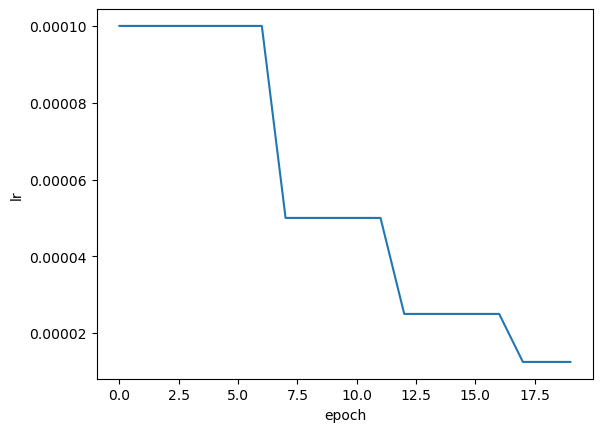

In [473]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [436]:
# Generate predictions for all images in the validation set

val_preds = model.predict(valid_dataset)


13/24 [===============>..............] - ETA: 35s

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 99s 4s/step


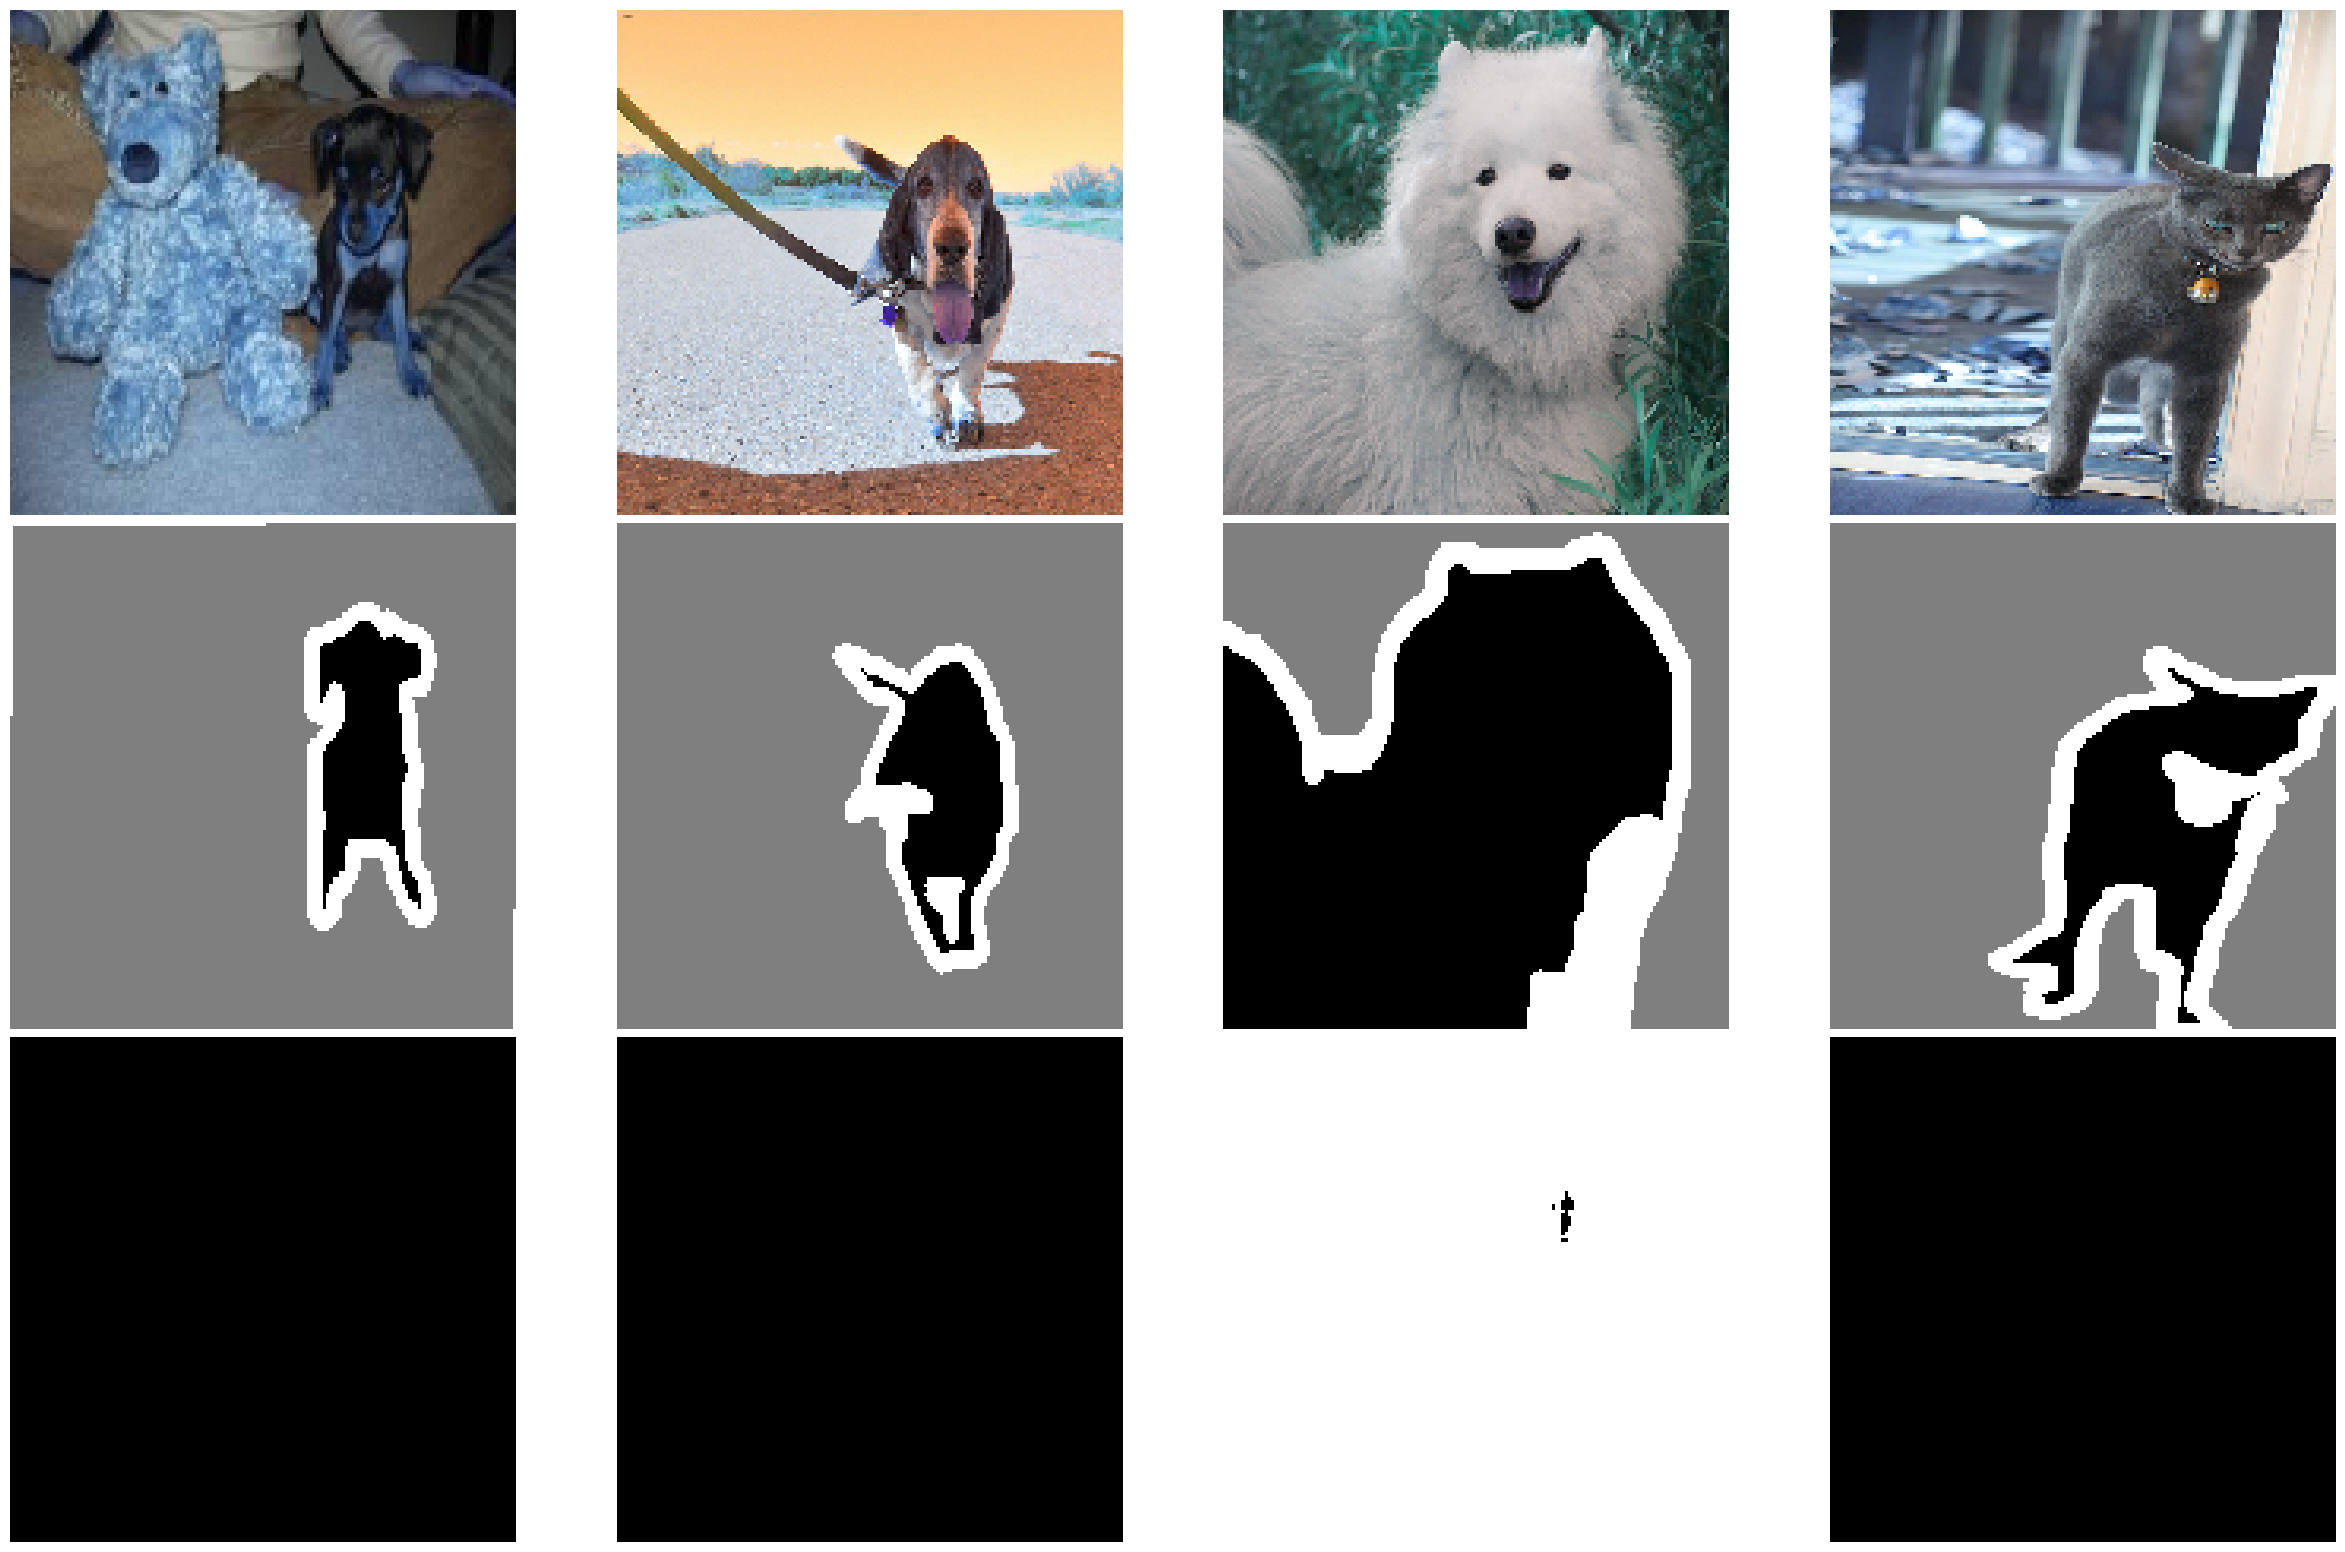

In [437]:

if INTERACTIVE_SESSION:
    pets.display_sample_image(val_preds)


In [478]:
model.evaluate(x=valid_dataset)

13/24 [===============>..............] - ETA: 9s - loss: 2.0467 - accuracy: 0.5787 

Corrupt JPEG data: premature end of data segment


24/24 [==============================] - 20s 809ms/step - loss: 2.0233 - accuracy: 0.5794


[2.0233242511749268, 0.5794029831886292]